# Reading Particles + Application to Halo detection with Yt/hop and Halo mass function

In this notebook we will :
* upload a Dyablo Particle file
* interface with Yt
* create a Halo Catalog, using HOP
* plot the volumic distribution of halo masses (aka halo mass function HMF) and compare it to some reference

In [1]:
import numpy as np
import h5py
import yt
import numpy as np
import matplotlib.pyplot as plt
import sys, platform, os
from CosmoUtils import *
from yt.extensions.astro_analysis.halo_analysis import HaloCatalog
from tqdm import tqdm
import matplotlib.cm as cm

In [2]:
plt.style.use('stylesheet.mplstyle')

In [3]:
import my_hmf_cmf_lib as mycmf

In [4]:
print(mycmf.TCMB)

2.7255


## Upload Particle file

In [ ]:
# nb_iter, zsnap = ["0000000",26.1272]
# nb_iter, zsnap = ["0000250",2.47551]
nb_iter, zsnap = ["0002850",0.0]

filename = f"cosmo_particles_particles_iter{nb_iter}.h5"

fpart = h5py.File(f'../datastageM2/{filename}', 'r')

positions = np.array(fpart['coordinates'])
print(np.shape(positions))

x=positions[:,0]
y=positions[:,1]
z=positions[:,2]
Npart=np.size(x)


# Uncomment if velocities are available in the Dyablo output
#vx = np.array(fpart['vx'])
#vy = np.array(fpart['vy'])
#vz = np.array(fpart['vz'])

(16777216, 3)


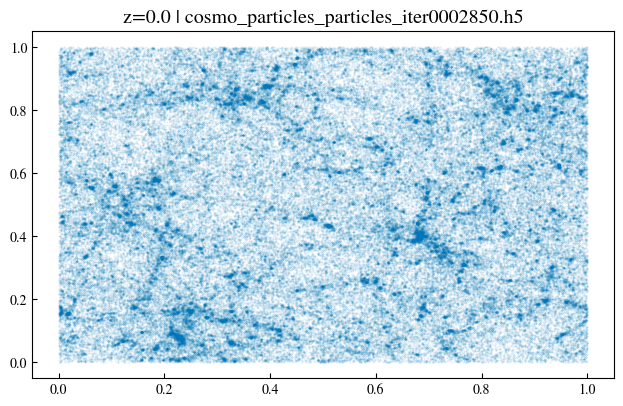

In [6]:
plt.figure()
plt.title(f"z={zsnap} | {filename}")
plt.scatter(x[::100],y[::100], alpha=0.15, s=0.15)
# plt.scatter(x[::10],y[::10], alpha=0.01, s=0.15)
# plt.scatter(x[::2],y[::2], alpha=0.01, s=0.03)
plt.show()

### Some run parameters

In [7]:
#grid size
# nx = 256
# ny = 256
# nz = 256

# grid_size = [nx,ny,nz]


In [8]:
L=164 #Mpc/h
H0org=67.00 # km/s/Mpc
om=0.3175 # total density parameter

# Computing the Particle Mass
H0=H0org*1e3/3.086e22
h=H0org/100.
rhoc=3*H0**2/(8*np.pi*6.67e-11) #kg/m^3
rho0 = rhoc * om
mpart=rho0*(L/h*3.086e22)**3/Npart #kg #either rhoc * om or rho0
print('particle mass [Solar Mass] = {:e}'.format(mpart/2e30))

particle mass [Solar Mass] = 3.440346e+10


In [9]:
grid_size = [L/h, L/h, L/h]

In [10]:
print(f"mean density : {rho0:.2e} kg/m^3")

mean density : 2.68e-27 kg/m^3


In [11]:
rho_MsunMpc3 = rho0 / 2e30 * 3.086e22**3 #Msun/Mpc^3
print(f"mean density : {rho_MsunMpc3:.2e} Msun/Mpc^3")

mean density : 3.94e+10 Msun/Mpc^3


## Interfacing with Yt

In [12]:
masses=np.ones(Npart) # dummy particle masses array as a set of unit masses
idx=np.arange(Npart) # monotonic indexes for particles

data = dict(
    particle_position_x=x,
    particle_position_y=y,
    particle_position_z=z,
    particle_velocity_x=x,#dummy with no vel
    particle_velocity_y=y,#dummy with no vel
    particle_velocity_z=z,#dummy with no vel
    particle_mass=masses,
    particle_index=idx
)
ds = yt.load_particles(data,length_unit=L*3.086e24,periodicity=(True,True,True),mass_unit=mpart*1e3)

yt : [INFO     ] 2025-04-10 07:27:14,561 Parameters: current_time              = 0.0
yt : [INFO     ] 2025-04-10 07:27:14,563 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-04-10 07:27:14,565 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-04-10 07:27:14,567 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-04-10 07:27:14,568 Parameters: cosmological_simulation   = 0


## Hop Launch

#### Catalog Creation using Hop via Yt

VERY LONG !

In [13]:
# hc = HaloCatalog(data_ds=ds, finder_method="hop",output_dir="./datastageM2/")

In [14]:
# hc.create() # launch in background

In [ ]:
fhalo = h5py.File('../datastageM2/ParticleData/ParticleData.0.h5', 'r') # upload Hop results

# fhalo = h5py.File(f'datastageM2/cosmo_iter{nb_iter}.h5', 'r') # upload Hop results

In [16]:
# fhalo.keys()

In [17]:
xh=np.array(fhalo['particle_position_x']) #HOP halo positions
yh=np.array(fhalo['particle_position_y']) #HOP halo positions
zh=np.array(fhalo['particle_position_z']) #HOP halo positions
mh=np.array(fhalo['particle_mass']) #HOP halo mass

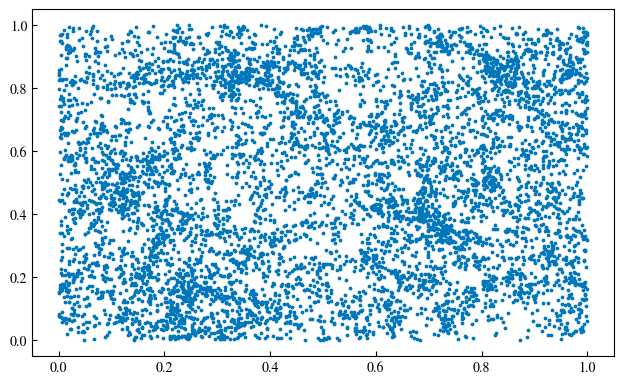

In [18]:
plt.figure()
#plt.scatter(x,y,alpha=0.05,s=0.5) # scatter plot of particle positions
plt.scatter(xh,yh,s=3.0) # scatter plot of halo positions

In [19]:
print(len(xh), "halos in the whole domain")

7084 halos in the whole domain


## Mass function

In [20]:
pars,results,s8_fid = mycmf.compute_init_power_spectrum(zsnap, H0org, mycmf.TCMB, om, mycmf.ob, h, mycmf.ns, mycmf.As)

Note: redshifts have been re-sorted (earliest first)


In [21]:
M_list = np.logspace(8,15,1000) #Msun/h

In [22]:
#compute the power spectrum for a given redshift
kh, _, pk = mycmf.compute_matter_power_spectrum(zsnap, pars, s8_fid)

n_ST_list = [mycmf.hmfcalc(M_list[i], kh, pk, "ST") for i in range(len(M_list))]

Note: redshifts have been re-sorted (earliest first)


127 127 127 127
127 127


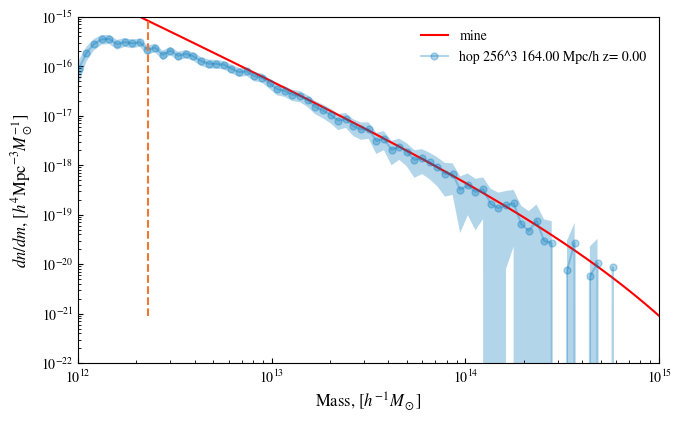

In [28]:
# Plot the reference HMF
plt.figure()
plt.plot(M_list, n_ST_list, color="red", label = "mine")
plt.yscale('log')
plt.xscale('log')

###### We compute the histogram of the halo mass for our simulation
bins_hmf=np.logspace(11,16,num=128)
bcen_hmf=0.5*(bins_hmf[1:]+bins_hmf[:-1])
db_hmf=bins_hmf[1:]-bins_hmf[:-1]
# Halo mass function using Hop mass estimate, note that masses must be given in Msol/h
# Note : hop mass is slightly underestimated compared to proper M200 calculation
myhmf,bmf=np.histogram(mh*h,bins=bins_hmf) #<<< msol/h

mydndm_hmf=myhmf/db_hmf/L**3
mydndm1_hmf=mydndm_hmf+3*np.sqrt(myhmf)/db_hmf/L**3 #3 sigma dispersion
mydndm2_hmf=mydndm_hmf-3*np.sqrt(myhmf)/db_hmf/L**3 #3 sigma dispersion
print(len(myhmf), len(mydndm_hmf), len(bcen_hmf), len(db_hmf))
print(len(mydndm1_hmf), len(mydndm2_hmf))
# Plot
plt.plot(bcen_hmf,mydndm_hmf,'-o',markersize=5,label='hop 256^3 {:5.2f} Mpc/h z={:5.2f}'.format(L,zsnap),alpha=0.3)
plt.fill_between(bcen_hmf,mydndm1_hmf,mydndm2_hmf,alpha=0.3)
plt.xlabel(r"Mass, $[h^{-1}M_\odot]$")
plt.ylabel(r"$dn/dm$, $[h^{4}{\rm Mpc}^{-3}M_\odot^{-1}]$");
plt.xlim([1e12,1e15])
plt.ylim([1e-22,1e-15])
plt.plot(np.ones(10)*100*mpart*h/2e30,np.linspace(np.min(n_ST_list),np.max(n_ST_list),10),'--')
plt.legend()

In [30]:
n_ST_list_bins = [mycmf.hmfcalc(bcen_hmf[i], kh, pk, "ST") for i in range(len(bcen_hmf))]

In [32]:
w = np.where((n_ST_list_bins < mydndm1_hmf) & (n_ST_list_bins > mydndm2_hmf))[0]

print(f"{bcen_hmf[w][0]:.2e}")

7.42e+12


In [35]:
print(f"{Mmin_finder(bcen_hmf, mydndm1_hmf, mydndm2_hmf, n_ST_list_bins):.2e}")

7.42e+12
